# CAP 6618 - Machine Learning for Computer Vision

Christian Garbin
Spring 2019

# Programming Project 3

## Starting point

In the experimental notebook we trained a network that achieved 99.13% accuracy on the training set.

In this notebook we will attempt to improve it using these techniques:

- More layers
- Batch normalization
- Image augmentation

## Current state of the art

According to [this site](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html), the best MNIST accuracy has 0.21% error rate, i.e 99.79% accuracy.

According to [LeCun's MNIST page](http://yann.lecun.com/exdb/mnist/), the best accuracy has an error rate of 0.23% (99.77% accuracy). To achieve that a "committee of 35 conv. net, 1-20-P-40-P-150-10 [elastic distortions]" was used.

Therefore, that's the maximum can we hope to achieve in these experiments.

# Step 1: Setup

First, make sure that you have installed Keras on your computer.

In [20]:
# Code from https://github.com/keras-team/keras 

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop
from keras import backend as K

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

## Step 1a: Auxiliary functions and constants

Some data manipulation and visualization functions.

Visualize Keras training accuracy and loss, given a `History` object collected from calling `fit()`.

In [22]:
# From https://keras.io/visualization/

def plot_keras_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

Train a model, validate on test data and show training loss/accuracy in graphical format.

In [23]:
def train_validate_analyze(model, batch_size, epochs):
    history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
    
    score = model.evaluate(x_test, y_test, verbose=1)
    print('Test loss:', score[0]) 
    print('Test accuracy:', score[1])
    
    plot_keras_history(history)

Number of classes in the MNIST dataset.

In [24]:
NUM_CLASSES = 10

# Step 2: Load, split and prepare the MNIST dataset

In [25]:
# Code from https://github.com/keras-team/keras 

# Re-load and re-shape the dataset

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


# Step 4: Baseline

This is the same network from the experimental notebook, repeated here to have a baseline.

In [29]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
__________

Train on 60000 samples, validate on 10000 samples
Epoch 1/11
60000/60000 [==============================] - 97s 2ms/step - loss: 0.2594 - acc: 0.9201 - val_loss: 0.0612 - val_acc: 0.9788
Epoch 2/11
60000/60000 [==============================] - 96s 2ms/step - loss: 0.0889 - acc: 0.9732 - val_loss: 0.0408 - val_acc: 0.9850
Epoch 3/11
60000/60000 [==============================] - 97s 2ms/step - loss: 0.0660 - acc: 0.9805 - val_loss: 0.0327 - val_acc: 0.9888
Epoch 4/11
60000/60000 [==============================] - 96s 2ms/step - loss: 0.0542 - acc: 0.9839 - val_loss: 0.0319 - val_acc: 0.9880
Epoch 5/11
60000/60000 [==============================] - 96s 2ms/step - loss: 0.0467 - acc: 0.9856 - val_loss: 0.0310 - val_acc: 0.9894
Epoch 6/11
60000/60000 [==============================] - 93s 2ms/step - loss: 0.0417 - acc: 0.9875 - val_loss: 0.0283 - val_acc: 0.9909
Epoch 7/11
60000/60000 [==============================] - 95s 2ms/step - loss: 0.0376 - acc: 0.9889 - val_loss: 0.0261 - val_acc

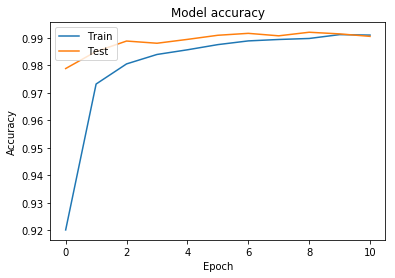

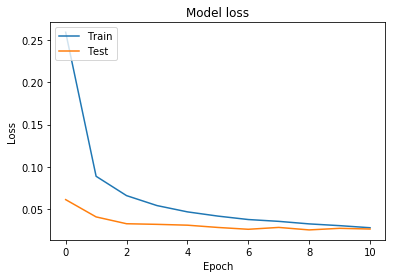

In [27]:
train_validate_analyze(model, batch_size=128, epochs=11)